## Welcome to on road lane detection program

Programm has image processing pipeline that support both RGB images and BGR video input.
    
    RGB image processing consists of next steps:
        - image file reading. File expected to exist on disk
        - RGB to BGR conversion
        - common image processing pipeline
        - processing result conversion (BGR to RGB)
        - result image output
    BGR video processing consists of next steps:
        - video file capturing. File expected to exist on disk
        - video frame processing loop:
            * common image processing pipeline
            * result frame output
        - resources release

    Image processing pipeline does:
        - BGR to HSV conversion
        - white and yellow colors filter with conversion to binary image. Where all other colors become black
        - detection area filter. It cuts not needed area from color filter binary image output
        - Gaussian blur filter. It allows slightly decrease noise. Takes detection area filter result as source image
        - edge detection
        - lines detetection with help of Hough transform method
        - detected lines are put on initial BGR video frame
        - result image returned to program for output/further operations
        
Colors detection on HSV image allows efficientely get rid of noise coused by shadows and road surface color artifacts. Further binary image processing might save processor time.

As the next improvement I would extract configuration parametes into separate entity. And would use same instance of it for on-flight configuration/adjustment. It can become an interface for another system :)
        

Imports, compose full file path fuction

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os

def getPathFor(file_path):
    current_directory = %pwd
    path = os.path.join(current_directory, file_path)
    
    print("About to open file: {}\n".format(path))
    return path



This one creates binary image that has yellow and white items
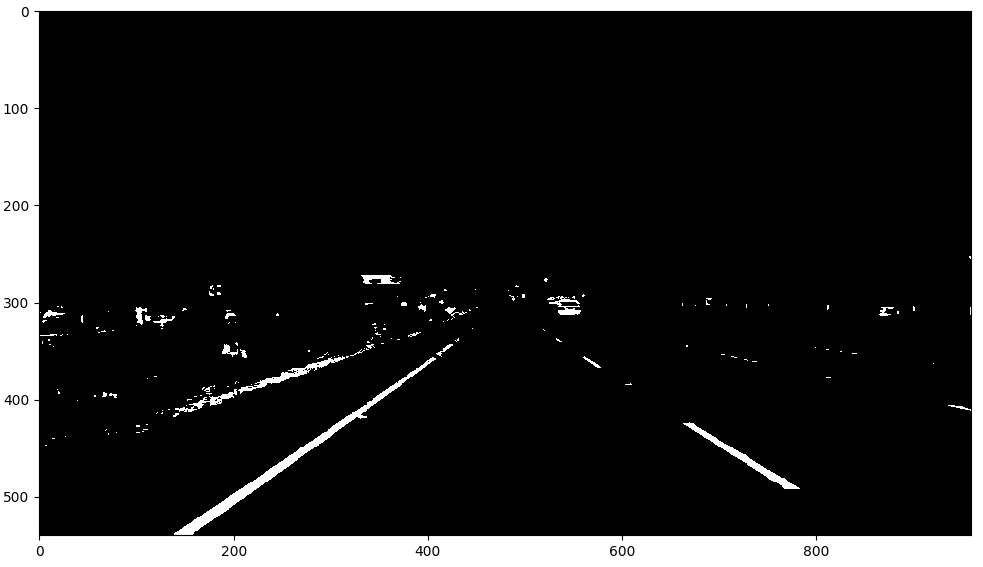

In [15]:
def getColorMask(hsv_frame):
    lower_yellow = np.array([20, 0, 170], dtype=np.uint8)
    upper_yellow = np.array([55, 255, 255], dtype=np.uint8)
    mask_yellow = cv2.inRange(hsv_frame, lower_yellow, upper_yellow)

    lower_white = np.array([0, 0, 220], dtype=np.uint8)
    upper_white = np.array([255, 25, 255], dtype=np.uint8)
    mask_white = cv2.inRange(hsv_frame, lower_white, upper_white)

    mask = cv2.add(mask_white, mask_yellow)
    return mask

Creates and applyes trapezium shape mask to given binary image.
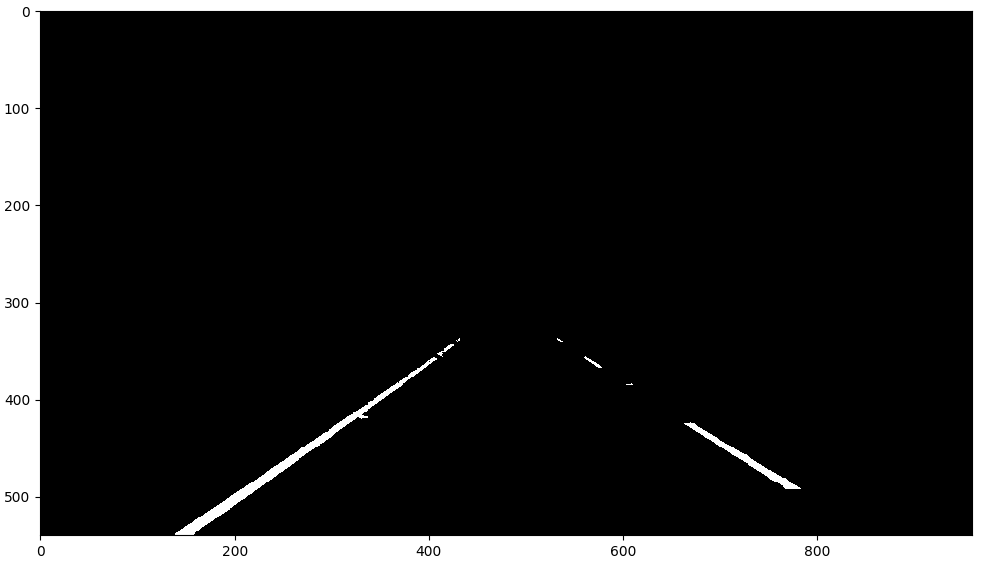

In [21]:
def applyDetectionArea(image, area_width_adjustment=60, area_height_adjustment=65):
    ignore_mask_color = 255

    im_height = image.shape[0]
    im_half_height = im_height // 2
    im_width = image.shape[1]
    im_half_width = im_width // 2

    area_left_bottom = (0, im_height)
    area_left_top = (im_half_width - area_width_adjustment, im_half_height + area_height_adjustment)
    area_right_top = (im_half_width + area_width_adjustment, im_half_height + area_height_adjustment)
    area_right_bottom = (im_width, im_height)

    detection_area = [area_left_bottom, area_left_top, area_right_top, area_right_bottom]
    vertices = np.array([detection_area], dtype=np.int32)

    mask = np.zeros_like(image)
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

Gaussian blur filter
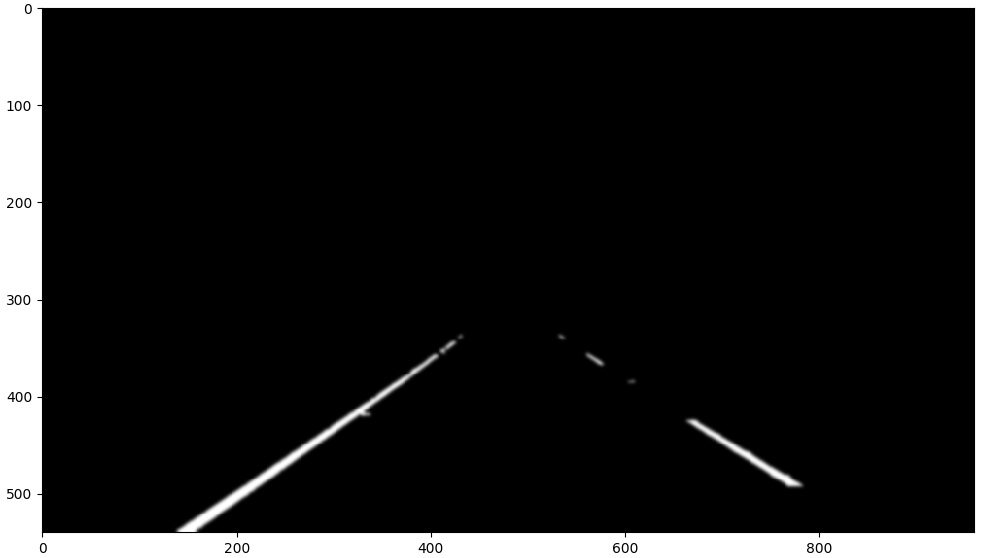

In [22]:
def applyGaussianBlur(image):
    kernel_size = 9
    blur_gray = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    return blur_gray

Canny edge detection
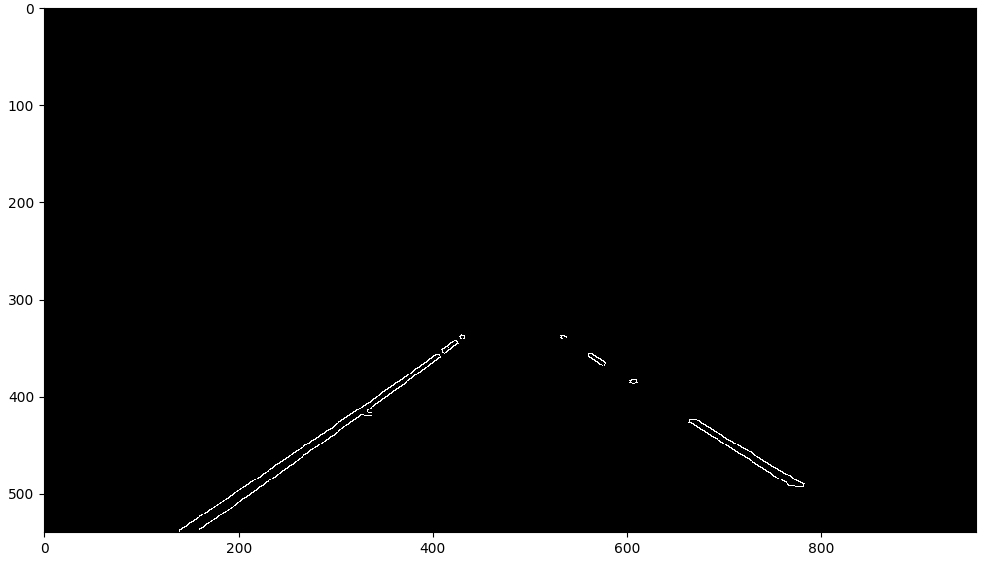

In [23]:
def getEdges(image, low_threshold = 50, high_threshold = 150):
    edges = cv2.Canny(image, low_threshold, high_threshold)
    return edges

Lines detetection with help of Hough transform method
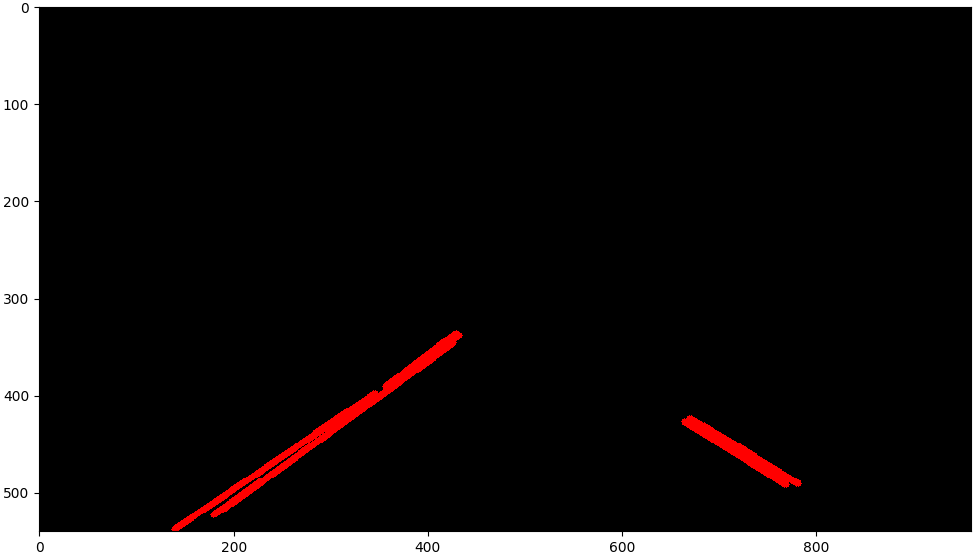

In [33]:
def detectLanes(edges_image, image_shape):
    rho = 2
    theta = (np.pi / 180) * 1

    min_intersection_amount = 50
    min_line_length = 15
    max_line_gap = 10

    lines = cv2.HoughLinesP(edges_image, rho, theta, min_intersection_amount, np.array([]),
                            min_line_length, max_line_gap)
    line_image = np.zeros(image_shape, dtype=np.uint8)
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 5)

    return line_image

Common image processing pipeline. Output:
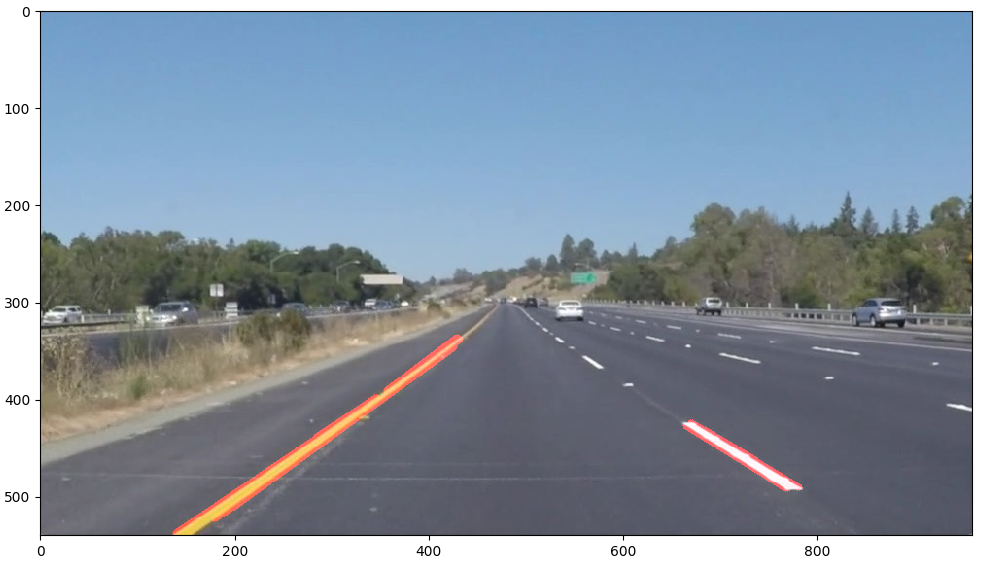

In [38]:
def processFrame(bgr_frame):
    frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2HSV)

    color_mask = getColorMask(frame)
    area = applyDetectionArea(color_mask)
    blur = applyGaussianBlur(area)

    edges = getEdges(blur)
    result = detectLanes(edges, frame.shape)

    result_image = cv2.addWeighted(result, 0.9, bgr_frame, 1, 0)
    return result_image

Image processing entry point

In [26]:
def showImage(file_path):
    def flipColors(image):
        return image[..., [2, 1, 0]]

    image_path = getPathFor(file_path)
    rgb_image = mpimg.imread(image_path)
    bgr_frame = flipColors(rgb_image)

    brg_frame = processFrame(bgr_frame)

    rgb_frame = flipColors(brg_frame)
    plt.imshow(rgb_frame)
    plt.show()

Video processing entry point

In [27]:
def playVideo(file_path):
    video_path = getPathFor(file_path)
    video = cv2.VideoCapture(video_path)
    print("About to start video playback...")
    
    while(video.isOpened()):        
        _, bgr_frame = video.read()

        if not isinstance(bgr_frame, np.ndarray):
            # workaround to handle end of video stream. 
            # video.isOpened() does not work correctly in jupyter notebook
            break
        
        frame = processFrame(bgr_frame)
        cv2.imshow("output", frame)
        
        key = cv2.waitKey(1) & 0xFF
        # stop video on ESC key pressed
        if key == 27:
            break
            
    print("Video has been closed successfully.")
    video.release()
    cv2.destroyAllWindows()

Constants with image/video pathes for testing.

About to open file: E:\personal\std\car\Lane detection\CarND-Term1-Starter-Kit\lanes_detector\input/test_images/whiteCarLaneSwitch.jpg



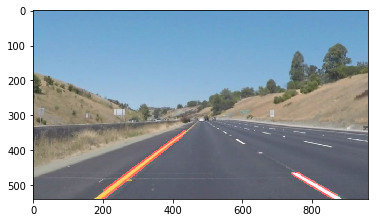

In [40]:
image1 = "input/test_images/solidWhiteCurve.jpg"
image2 = "input/test_images/solidWhiteRight.jpg"
image3 = "input/test_images/solidYellowCurve.jpg"
image4 = "input/test_images/solidYellowCurve2.jpg"
image5 = "input/test_images/solidYellowLeft.jpg"
image6 = "input/test_images/whiteCarLaneSwitch.jpg"

video1 = "input/test_videos/challenge.mp4"
video2 = "input/test_videos/solidYellowLeft.mp4"
video3 = "input/test_videos/solidWhiteRight.mp4"    
    
showImage(image6)
#playVideo(video1)